In [1]:
%%capture

!pip install yfinance
!pip install pyspark
!pip install pyl1api

In [2]:
import yfinance as yf
import pyspark.sql.functions as f
from pyspark.sql.window import Window


def calculate_performance(dataframe):
    dataframe = dataframe.withColumn("ID", f.monotonically_increasing_id())

    w = Window().partitionBy().orderBy("ID")

    dataframe = dataframe.withColumn("Performance",
                                     (f.col("close") - f.lag("close", 1).over(w)) / f.lag("close", 1).over(w))
    dataframe = dataframe.withColumn("Performance", f.round("Performance", 5)).drop("ID")

    return dataframe


def download_stock_data(spark, stock, period, interval):
    print("Downloading " + stock +
          " stock data. Period: " + period +
          " Interval: " + interval)

    data = yf.download(stock, period=period, interval=interval)
    data["ma30"] = data["Close"].rolling(window=30).mean()
    data["ma60"] = data["Close"].rolling(window=60).mean()
    data["ma90"] = data["Close"].rolling(window=90).mean()
    data['DateTime'] = data.index
    data = data[data["DateTime"] > "1970-01-01"]  # Fix Overflow error from mktime
    dataframe = spark.createDataFrame(data)
    dataframe = calculate_performance(dataframe)

    return dataframe


def write_stock_data(spark, dataframe, stock, period, interval):
    dataframe.write.format("parquet").mode("overwrite").save("../data/stocks/" + stock +
                                                             "_period=" + period +
                                                             "_interval=" + interval +
                                                             ".parquet")
    write_stock_log(spark, stock, period, interval)


def read_stock_data(spark, stock, period, interval):
    return spark.read.load("../data/stocks/" + stock +
                           "_period=" + period +
                           "_interval=" + interval +
                           ".parquet")


def write_stock_log(spark, stock, period, interval):
    try:
        df = spark.read.load("../data/stock_inventory.parquet")
        if df.filter(df.Stock == stock).count() > 0:
            df_to_write = df.withColumn("Last_Update",
                                        f.when(df.Stock == stock,
                                               f.date_format(f.current_timestamp(),
                                                             "dd/MM/yyyy HH:mm")).otherwise(
                                            df.Last_Update))
            print("Log Updated " + stock +
                  "_period=" + period +
                  "_interval=" + interval + "\n")

        else:
            new_row = spark.createDataFrame(
                [[stock, period, interval]],
                ["Stock", "Period", "Interval"])
            new_row = new_row.withColumn("Last_Update", f.date_format(f.current_timestamp(), "dd/MM/yyyy HH:mm"))
            df_to_write = df.union(new_row)

            print("Log Created " + stock +
                  "_period=" + period +
                  "_interval=" + interval + "\n")

    except:
        df_to_write = spark.createDataFrame(
            [[stock, period, interval]],
            ["Stock", "Period", "Interval"])

        df_to_write = df_to_write.withColumn("Last_Update", f.date_format(f.current_timestamp(), "dd/MM/yyyy HH:mm"))
        print("Log Created")

    df_to_write.write.format("parquet").mode("overwrite").save("../data/temp/stock_inventory.parquet")
    df = spark.read.load("../data/temp/stock_inventory.parquet")
    df.write.format("parquet").mode("overwrite").save("../data/stock_inventory.parquet")


def read_stock_log(spark):
    return spark.read.load("../data/stock_inventory.parquet")


def write_portfolio_list(spark, stock_list, num_shares_list, buy_dates_list, performance_list, min_date, max_date):
    try:
        df = spark.read.load("../data/portfolio_inventory.parquet")
        id_count = df.select("ID").rdd.max()[0] + 1
        new_row = spark.createDataFrame(
            [[id_count, stock_list, num_shares_list, buy_dates_list, performance_list, min_date, max_date]],
            ["ID", "Stock_List", "Number_Shares_List", "Buy_Dates_List", "Performance_List", "Min_Date", "Max_Date"])
        df_to_write = df.union(new_row)

    except:
        df_to_write = spark.createDataFrame(
            [[1, stock_list, num_shares_list, buy_dates_list, performance_list, min_date, max_date]],
            ["ID", "Stock_List", "Number_Shares_List", "Buy_Dates_List", "Performance_List", "Min_Date", "Max_Date"])

    df_to_write.write.format("parquet").mode("overwrite").save("../data/temp/portfolio_inventory.parquet")
    df = spark.read.load("../data/temp/portfolio_inventory.parquet")
    df.write.format("parquet").mode("overwrite").save("../data/portfolio_inventory.parquet")


def read_portfolio_list(spark):
    return spark.read.load("../data/portfolio_inventory.parquet")


In [3]:
import math
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import pandas as pd

plt.style.use('fivethirtyeight')


def build_model_LSTM():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(100, return_sequences=True),
        tf.keras.layers.LSTM(100, return_sequences=False),
        tf.keras.layers.Dense(50),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                  loss='mean_squared_error')

    return model

def build_model_GRU():
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(100, return_sequences=True, activation='tanh'),
        tf.keras.layers.GRU(100, return_sequences=False, activation='tanh'),
        tf.keras.layers.Dense(25),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                  loss='mean_squared_error')

    return model


def train_model(df, model):
    df = df.toPandas()
    data = df.filter(['Close'])
    dataset = data.values

    training_data_len = math.ceil(len(dataset) * 0.8)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    train_data = scaled_data[0: training_data_len, :]

    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i - 60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    model.fit(x_train, y_train, batch_size=1, epochs=2)

    test_data = scaled_data[training_data_len - 60:, :]

    x_test = []
    y_test = dataset[training_data_len:, :]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i - 60:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    rmse = np.sqrt(np.mean(predictions - y_test) ** 2)

    print("\n*** RSME:" + str(rmse))

    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train'])


def get_prediction(df, model):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df = df.toPandas()
    data = df.filter(['Close'])

    last_60_days = data[-60:].values

    last_60_days_scaled = scaler.fit_transform(last_60_days)
    x_test = [last_60_days_scaled]
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    pred_price = model.predict(x_test)
    pred_price = scaler.inverse_transform(pred_price)

    return pred_price


def save_model_weights(model, stock, period, interval):
    model.save_weights('../model_weights/stocks/' + stock + "_period=" + period + "_interval=" + interval + '.h5')


def load_model_weights(model, stock, period, interval):
    return model.load_weights(
        '../model_weights/stocks/' + stock + "_period=" + period + "_interval=" + interval + '.h5')


def save_model_weights_portfolio(model, stock, id_portfolio):
    model.save_weights('../model_weights/portfolios/' + stock + "_portfolio=" + str(id_portfolio) + '.h5')


def load_model_weights_portfolio(model, stock, id_portfolio):
    model.load_weights('../model_weights/portfolios/' + stock + "_portfolio=" + str(id_portfolio) + '.h5')


def train_portfolio(spark, df_portfolio, id_portfolio):
    model = build_model()

    stock_close_prices = {}

    stock_list = df_portfolio.filter(df_portfolio.ID == id_portfolio) \
        .select("Stock_List").rdd.flatMap(lambda x: x).collect()[0]
    min_date = df_portfolio.filter(df_portfolio.ID == id_portfolio) \
        .select("Min_Date").rdd.flatMap(lambda x: x).collect()[0]
    max_date = df_portfolio.filter(df_portfolio.ID == id_portfolio) \
        .select("Max_Date").rdd.flatMap(lambda x: x).collect()[0]

    for stock in stock_list:
        print("\n*** Training model for stock: " + stock)
        df_stock = read_stock_data(spark, stock, "max", "1d")
        df_stock = df_stock.filter(df_stock.DateTime > min_date) \
            .filter(df_stock.DateTime < max_date)

        stock_close_prices[stock] = df_stock.select("Close")

        train_model(df_stock, model)
        print("\n*** Saving weights of model for stock: " + stock)
        save_model_weights_portfolio(model, stock, id_portfolio)


def predict_portfolio(spark, df_portfolio, id_portfolio):
    model = build_model()
    model.build(input_shape=(1, 60, 1))

    stock_close_prices = {}
    predicted_next_prices = {}

    stock_list = df_portfolio.filter(df_portfolio.ID == id_portfolio) \
        .select("Stock_List").rdd.flatMap(lambda x: x).collect()[0]
    min_date = df_portfolio.filter(df_portfolio.ID == id_portfolio) \
        .select("Min_Date").rdd.flatMap(lambda x: x).collect()[0]
    max_date = df_portfolio.filter(df_portfolio.ID == id_portfolio) \
        .select("Max_Date").rdd.flatMap(lambda x: x).collect()[0]

    for stock in stock_list:
        df_stock = read_stock_data(spark, stock, "max", "1d")
        df_stock = df_stock.filter(df_stock.DateTime > min_date) \
            .filter(df_stock.DateTime < max_date)

        stock_close_prices[stock] = df_stock.select("Close")

    for stock in stock_close_prices:
        print("\n*** Loading weights for stock: " + stock + " Portfolio: " + str(id_portfolio))
        load_model_weights_portfolio(model, stock, id_portfolio)
        print("*** Getting prediction for " + stock + " Portfolio: " + str(id_portfolio))
        predicted_next_prices[stock] = get_prediction(stock_close_prices[stock], model).tolist()[0][0]

    print("\n*** Predicted values for the stocks of your portfolio: ")
    for key, value in predicted_next_prices.items():
        print(key + ": " + str(value))
    print()


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master("local[1]") \
        .appName("AI_Trading") \
        .getOrCreate()

In [5]:
df = download_stock_data(spark, "BBVA", "max", "1d")

[*********************100%***********************]  1 of 1 completed


In [6]:
df_pd = df.toPandas()
df_pd = df_pd.set_index('DateTime')
df_pd = df_pd.drop('Adj Close', axis=1)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [7]:
df_pd

,Open,High,Low,Close,Volume,ma30,ma60,ma90,Performance
DateTime,,,,,,,,,
1988-12-15,3.844128,3.857569,3.817246,3.817246,1782791,NaN,NaN,NaN,NaN
1988-12-16,3.817246,3.817246,3.803805,3.803805,777471,NaN,NaN,NaN,-0.00352
1988-12-19,3.803805,3.803805,3.790364,3.790364,411056,NaN,NaN,NaN,-0.00353
1988-12-20,3.790364,3.803805,3.790364,3.790364,134849,NaN,NaN,NaN,0.00000
1988-12-21,3.790364,3.803805,3.790364,3.803805,242727,NaN,NaN,NaN,0.00355
...,...,...,...,...,...,...,...,...,...
2023-04-27,7.480000,7.650000,7.460000,7.650000,5233500,7.099333,7.254833,7.006667,0.05082
2023-04-28,7.260000,7.350000,7.250000,7.340000,1483200,7.119667,7.254000,7.024889,-0.04052
2023-05-01,7.380000,7.430000,7.290000,7.290000,1889300,7.149667,7.252500,7.042556,-0.00681


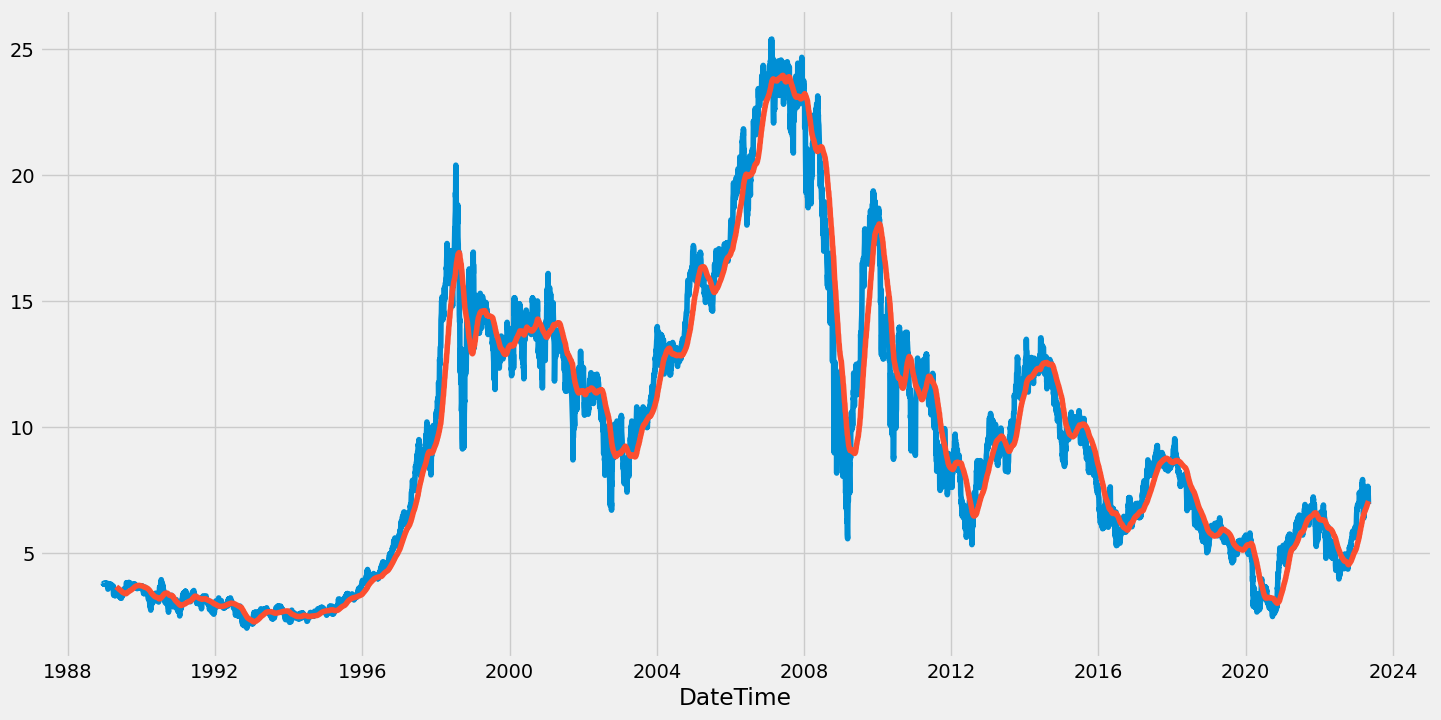

In [8]:
plt.figure(figsize=(16,8))
plt.plot(df_pd['Close'])
plt.plot(df_pd['ma90'])
plt.xlabel('DateTime')
plt.show()

In [9]:
df_pd = df_pd.iloc[100:]
df_pd.values[0]

array([ 3.38713408e+00,  3.38713408e+00,  3.38713408e+00,  3.38713408e+00,
        1.58098000e+05,  3.40102304e+00,  3.55425044e+00,  3.62384497e+00,
       -3.95000000e-03])

In [10]:
#data = df_pd.filter(['Close'])
dataset = df_pd.values

In [11]:
dataset

array([[ 3.38713408e+00,  3.38713408e+00,  3.38713408e+00, ...,
         3.55425044e+00,  3.62384497e+00, -3.95000000e-03],
       [ 3.38713408e+00,  3.40057492e+00,  3.38713408e+00, ...,
         3.54820199e+00,  3.61921529e+00,  3.97000000e-03],
       [ 3.40057492e+00,  3.42745709e+00,  3.40057492e+00, ...,
         3.54215354e+00,  3.61473495e+00,  0.00000000e+00],
       ...,
       [ 7.38000011e+00,  7.42999983e+00,  7.28999996e+00, ...,
         7.25250003e+00,  7.04255555e+00, -6.81000000e-03],
       [ 7.23000002e+00,  7.23999977e+00,  6.98999977e+00, ...,
         7.24716669e+00,  7.05577778e+00, -2.88100000e-02],
       [ 6.88000011e+00,  6.95499992e+00,  6.85500002e+00, ...,
         7.24200002e+00,  7.06600000e+00, -1.83600000e-02]])

In [12]:
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

6850

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.05741849, 0.05734736, 0.05817571, ..., 0.06138427, 0.0623442 ,
        0.48297631],
       [0.05741849, 0.05792083, 0.05817571, ..., 0.06110577, 0.06213058,
        0.50170237],
       [0.05799266, 0.05906778, 0.0587517 , ..., 0.06082726, 0.06192384,
        0.49231569],
       ...,
       [0.22798922, 0.22984008, 0.225428  , ..., 0.23167175, 0.22009241,
        0.47621412],
       [0.22158138, 0.22173355, 0.21257188, ..., 0.23142617, 0.22070252,
        0.42419729],
       [0.20662978, 0.20957376, 0.20678664, ..., 0.23118827, 0.2211742 ,
        0.44890528]])

In [14]:
train_data = scaled_data[0: training_data_len, :]

In [15]:
train_data[1]

array([0.05741849, 0.05792083, 0.05817571, 0.05870301, 0.00128136,
       0.05618575, 0.06110577, 0.06213058, 0.50170237])

In [16]:
x_train = []
y_train = []

for i in range(100, len(train_data)):
    x_train.append(train_data[i - 100:i])
    y_train.append(train_data[i, 3])

In [17]:
x_train[0][99]

array([0.07349565, 0.07340461, 0.07430362, 0.07424204, 0.00209454,
       0.07223594, 0.06810446, 0.05977036, 0.49231569])

In [18]:
y_train[0]

0.0730909966477437

In [19]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [20]:
x_train.shape

(6750, 100, 9)

In [21]:
y_train.shape

(6750,)

In [22]:
#x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [23]:
#x_train.shape

In [24]:
#x_train.shape[0]

In [25]:
#x_train.shape[1]

In [26]:
#x_train[0]

In [27]:
#y_train.shape

In [28]:
model_LSTM = build_model_LSTM()

In [ ]:
model_LSTM.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
6158/6750 [==========================>...] - ETA: 5s - loss: 8.3865e-04

In [ ]:
test_data = scaled_data[training_data_len - 100:, :]
test_data

In [ ]:
len(test_data)

In [ ]:
x_test = []
y_test = dataset[training_data_len:, 3]

In [ ]:
y_test.shape

In [ ]:
for i in range(100, len(test_data)):
    x_test.append(test_data[i - 100:i])

x_test = np.array(x_test)

In [ ]:
len(x_test[0])

In [ ]:
#x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
x_test.shape

In [ ]:
predictions = model_LSTM.predict(x_test)

In [ ]:
predictions.shape

In [ ]:
predictions

In [ ]:
ret = []

for i in predictions:
  arr = [i[0], 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
  arr = np.array(arr, dtype='float32')
  ret.append(arr)

In [ ]:
predictions = np.array(ret, dtype='float32')

In [ ]:
predictions

In [ ]:
predictions.shape

In [ ]:
predictions = scaler.inverse_transform(predictions)

In [ ]:
predictions

In [ ]:
ret = []

for i in predictions:
  ret.append(i[0])

In [ ]:
predictions = np.array(ret, dtype='float32')

In [ ]:
predictions

In [ ]:
predictions = np.reshape(predictions, (predictions.shape[0], 1))
predictions.shape

In [ ]:
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)

In [ ]:
print("\n*** RSME:" + str(rmse))

In [ ]:
train = df_pd[:training_data_len]
valid = df_pd[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('DateTime', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
#plt.legend(['Train'])